In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)

#get rid of future warnings with seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Analysis

### Questions

> - Is there some association between personal characteristics and the fact that person obtained Personal Loan (Loan Fact)? If so:
> - What are those Main Characteristics that has a higher association with Loan Fact and what the strength of correlation?
> - What the Segments of Main Characteristics, that has a higher strength of association with  Personal Loan?
> - What is the sample of Data with persons from Main Segments.

## Exploratory data analysis

In [4]:
df = pd.read_csv('df.csv')

###  Is there some association between personal characteristics and the fact that person obtained Personal Loan?

Let's check what the values or group of values of each variable lies inside group that have 'Personal Loan' and don't have that.

start with 

#### QUANTATIVE VARIABLES

['Age', 'Income', 'CCAvg', 'Mortgage']

In [12]:
quant_df = df[['Personal Loan',  'Experience','Age', 'Income', 'CCAvg', 'Mortgage']].copy()

#### Correlation Table

In [13]:
quant_df.corr()

,Personal Loan,Experience,Age,Income,CCAvg,Mortgage
Personal Loan,1.000000,-0.008338,-0.007726,0.502462,0.366891,0.142095
Experience,-0.008338,1.000000,0.994010,-0.046959,-0.049889,-0.011046
Age,-0.007726,0.994010,1.000000,-0.055269,-0.052030,-0.012539
Income,0.502462,-0.046959,-0.055269,1.000000,0.645993,0.206806
CCAvg,0.366891,-0.049889,-0.052030,0.645993,1.000000,0.109909
Mortgage,0.142095,-0.011046,-0.012539,0.206806,0.109909,1.000000


#### Heat map

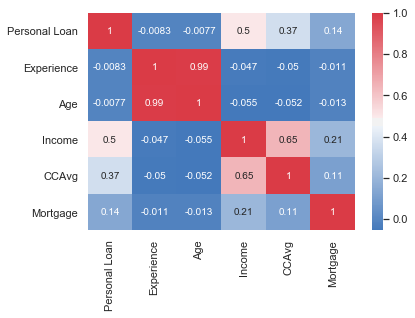

In [14]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(quant_df.corr(), cmap = cmap, annot = True);

##### Pairwise comprasion 'Experience' with other quantitive variables

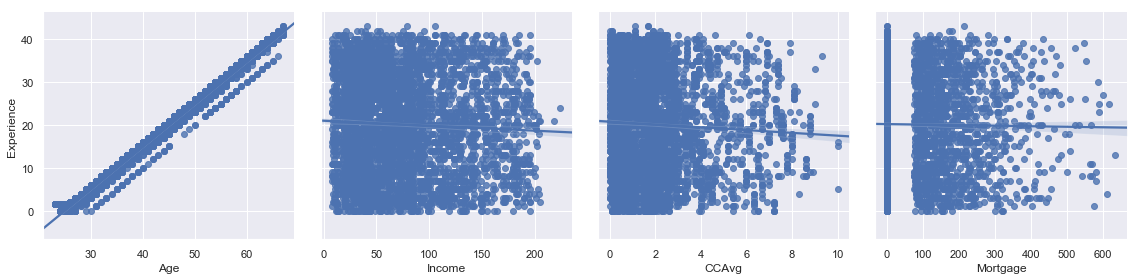

In [11]:
ncol = ['Age', 'Income','CCAvg', 'Mortgage']
grid = sns.PairGrid(df, y_vars = 'Experience', x_vars = ncol, height = 4)
grid.map(sns.regplot);

Since we found strong association between 'Age' and 'Experience' we decided to exclude 'Experience' from analysis to avoid multicollinearity.

Get association coefficients for 'Personal Loan' and exclude it's and "Experience" data from series

In [16]:
# get association coefficients for 'Personal Loan' and exclude it's data from series
quant_df.corr()['Personal Loan'][2:]

Age        -0.007726
Income      0.502462
CCAvg       0.366891
Mortgage    0.142095
Name: Personal Loan, dtype: float64

The chart showing comrasion of strength of association between 'Personal Loan' and different variables

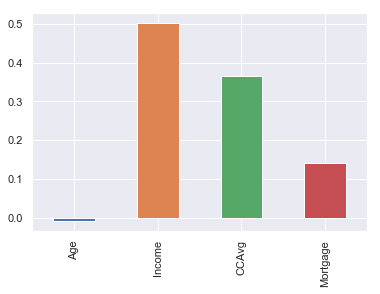

In [18]:
quant_df.corr()['Personal Loan'][2:].plot.bar();

**'Age'** and **'Mortgage'** both has very low cor.coef with Personal Loan. We may say that only **'Income'** and **'CCAvg**' has association with 'Personal Loan'

Let's check our confidense about this statment with logistic regression model:

In [19]:
import statsmodels.api as sm

In [20]:
quant_df['intercept'] = 1
log_mod = sm.Logit(quant_df['Personal Loan'], quant_df[['intercept', 'Age', 'Income', 'CCAvg', 'Mortgage']]).fit()

Optimization terminated successfully.
         Current function value: 0.200574
         Iterations 8


In [21]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4995
Method:                           MLE   Df Model:                            4
Date:                Tue, 02 Apr 2019   Pseudo R-squ.:                  0.3657
Time:                        08:44:30   Log-Likelihood:                -1002.9
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                4.743e-249
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.5144      0.308    -21.155      0.000      -7.118      -5.911
Age            0.0080      0.005      1.550      0.121      -0.002       0.018
Income         0.0351      0.002     22.313      0.000       0.032       0.038
CCAvg          0.0688      0.029      2.409      0.016       0.013       0.125
Mortgage       0.0007      0.000      1.757      0.079   -8.49e-05       0.002
==============================================================================
"""

#### The bar chart of P-Values distribution and threshold line 

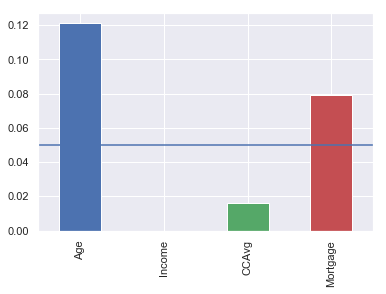

In [32]:
# exclude 'intercept'
log_mod.pvalues[1:5].plot.bar()
plt.axhline(y = 0.05);

**We can say with confidence** that 'Income' and 'CCAvg' both has statisticaly significant association with 'Personal Loan', since  their p-value in logistic regression < 0.05

#### The bar chart of coefficient distribution 

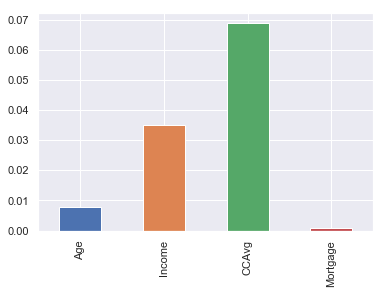

In [33]:
# exclude 'intercept'
log_mod.params[1:5].plot.bar();

**'CCAvg'** has strongest association with 'Personal Loan'

#### Filter columns with P-values less then 0.05 and store variables and it's coefficients into the dictionary

In [34]:
quant_df_main = {}
for i in log_mod.params[1:5].to_dict().keys():
    if log_mod.pvalues[i] < 0.05:
        quant_df_main[i] = log_mod.params[i]
    else:
        continue

In [35]:
quant_df_main

{'Income': 0.035086794726785976, 'CCAvg': 0.06879405526062024}

#### Compute the odds

In [36]:
quant_df_main_odds = {k : np.exp(v) for k, v in quant_df_main.items()}

In [37]:
quant_df_main_odds

{'Income': 1.0357095990302452, 'CCAvg': 1.0712155752174697}

### Conclusion:

'Personal Loan' has statisticaly significant association with:

> -  'Income' : coef = 0.03508
> -  'CCAvg' : coef = 0.06879

Both variables are positively associated with 'Personal Loan'. As soon as both have one unit as $1000 we may say the following:

> - **For each $1000 increase in 'Income'** we expect the odds to sell Personal Loan to increase by 3.57%, holding everything else constant

> - **For each $1000 increase in 'CCAvg'** we expect the odds to sell Personal Loan to increase by 7.12%, holding everything else constant

<br>

### CATEGORICAL VARIABLES

'ZIP Code', 'Family', 'Education'

'Family' and 'Education' are ordinal categorical variables so we may apply logistic regression direct to them. 'ZIP Code' is nominal, so we need to build dummy variables to check the association existence

In [38]:
cat_df = df[['ZIP Code', 'Family', 'Education', 'Personal Loan']].copy()

<br>

### 'Family' and  'Education'

Correlation table

In [39]:
cat_df.corr()

,Family,Education,Personal Loan
Family,1.000000,0.064929,0.061367
Education,0.064929,1.000000,0.136722
Personal Loan,0.061367,0.136722,1.000000


In [40]:
cat_df.corr()['Personal Loan'][0:2]

Family       0.061367
Education    0.136722
Name: Personal Loan, dtype: float64

The chart showing comprasion of stregth of corelation 'Personal Loan' with different variables

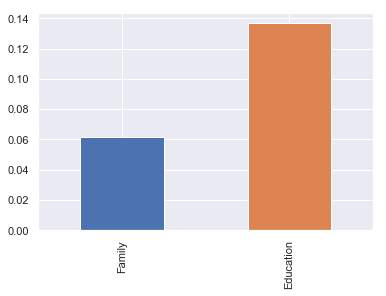

In [41]:
cat_df.corr()['Personal Loan'][0:2].plot.bar();

**'Family'** and **'Education'** has low association with 'Personal Loan'

Let's check our confidence with logistic regretion


In [42]:
cat_df['intercept'] = 1
log_mod = sm.Logit(cat_df['Personal Loan'], cat_df[['intercept', 'Family', 'Education']]).fit()

Optimization terminated successfully.
         Current function value: 0.305406
         Iterations 7


In [43]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                 0.03415
Time:                        15:12:22   Log-Likelihood:                -1527.0
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                 3.575e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.7670      0.175    -21.574      0.000      -4.109      -3.425
Family         0.1623      0.042      3.863      0.000       0.080       0.245
Education      0.5487      0.059      9.260      0.000       0.433       0.665
==============================================================================
"""

**We can say with confidence** that 'Family' and 'Education' both has statisticaly significant association with 'Personal Loan', since  their p-value in logistic regression < 0.05

#### The bar chart of coefficient distribution 

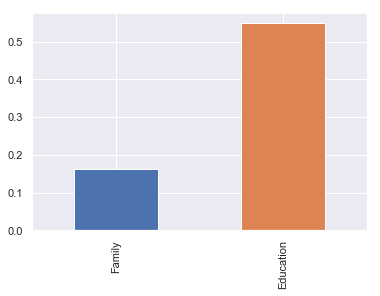

In [44]:
# exclude 'intercept'
log_mod.params[1:3].plot.bar();

**'Education'** has strongest association with 'Personal Loan'

#### Filter columns with P-values less then 0.05 and store variables and it's coefficients into the dictionary

In [45]:
cat_df_main = {}
for i in log_mod.params[1:3].to_dict().keys():
    if log_mod.pvalues[i] < 0.05:
        cat_df_main[i] = log_mod.params[i]
    else:
        continue

In [46]:
cat_df_main

{'Family': 0.1623178507480375, 'Education': 0.5487286631107698}

#### Compute the odds

In [47]:
cat_df_odds = {k : np.exp(v) for k, v in cat_df_main.items()}

In [48]:
cat_df_odds

{'Family': 1.1762340487826346, 'Education': 1.731050869500249}

### Conclusion:

'Personal Loan' has statisticaly significant association with:

> -  'Family' : coef = 0.16231
> -  'Education' : coef = 0.54873

Both variables are positively associated with 'Personal Loan'. We may say the following:

> - **For each unit increase in 'Family'** we expect the odds to sell Personal Loan to increase by 17.62%, holding everything else constant

> - **For each unit increase in 'Education'** we expect the odds to sell Personal Loan to increase by 73.11%, holding everything else constant

<br>

### 'ZIP Code'

In [49]:
cat_df.head()

,ZIP Code,Family,Education,Personal Loan,intercept
0,91107,4,1,0,1
1,90089,3,1,0,1
2,94720,1,1,0,1
3,94112,1,2,0,1
4,91330,4,2,0,1


In [50]:
zip_df = cat_df[['Personal Loan', 'intercept','ZIP Code']].copy()

In [51]:
zip_df.head(2)

,Personal Loan,intercept,ZIP Code
0,0,1,91107
1,0,1,90089


Lets check how we can group the 'Zip Code' values to minimize the number of dummies

In [52]:
zip_df['ZIP Code'].nunique()

467

In [53]:
zip_df['ZIP Code'].str[0:3].nunique()

57

In [54]:
zip_df['ZIP Code'].str[0:2].nunique()

7

In [55]:
zip_df['ZIP Code'].str[0:2].value_counts()

94    1472
92     988
95     815
90     703
91     565
93     417
96      40
Name: ZIP Code, dtype: int64

Guess this set is okay for the first view since we assume that the initial campaign of selling Personal Loans was evenly spreaded through all zip codes.

Let's get dummies...

In [56]:
dum_zip_df = zip_df.copy()

In [57]:
dum_zip_df['ZIP Code'] = dum_zip_df['ZIP Code'].str[0:2]

In [58]:
dum_zip_df.head(2)

,Personal Loan,intercept,ZIP Code
0,0,1,91
1,0,1,90


In [59]:
dum_zip_df = pd.get_dummies(dum_zip_df, prefix = "Z", drop_first = True)

In [60]:
dum_zip_df.head(2)

,Personal Loan,intercept,Z_91,Z_92,Z_93,Z_94,Z_95,Z_96
0,0,1,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0


Fit a logic model

In [61]:
#exclude 'Personal Loan' from independ vars
dum_zip_df_columns = dum_zip_df.columns.drop('Personal Loan').tolist()

In [62]:
log_mod = sm.Logit(dum_zip_df['Personal Loan'], dum_zip_df[dum_zip_df_columns]).fit()

Optimization terminated successfully.
         Current function value: 0.316143
         Iterations 6


In [63]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4993
Method:                           MLE   Df Model:                            6
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:               0.0001931
Time:                        15:12:24   Log-Likelihood:                -1580.7
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                    0.9962
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.2505      0.128    -17.521      0.000      -2.502      -1.999
Z_91           0.0234      0.191      0.122      0.903      -0.352       0.399
Z_92          -0.0019      0.168     -0.011      0.991      -0.331       0.328
Z_93           0.0875      0.206      0.425      0.671      -0.316       0.491
Z_94          -0.0182      0.157     -0.116      0.908      -0.325       0.289
Z_95           0.0327      0.174      0.187      0.851      -0.309       0.374
Z_96          -0.2618      0.614     -0.426      0.670      -1.465       0.941
==============================================================================
"""

**We can say with confidence** that any ZIP Code does not have statisticaly significant association with 'Personal Loan', since  their p-value in logistic regression > 0.05

# <br>

### BINARY VARIABLES

'Securities Account', 'CD Account', 'Online', 'Credit Card'

In [64]:
bin_df = df[['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']].copy()

In [65]:
bin_df.head()

,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


Correlation coefficients

In [66]:
bin_df.corr()['Personal Loan']

Personal Loan         1.000000
Securities Account    0.021954
CD Account            0.316355
Online                0.006278
CreditCard            0.002802
Name: Personal Loan, dtype: float64

The chart showing comprasion of stregth of association between 'Personal Loan' and different variables

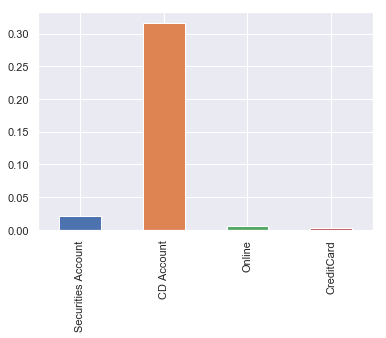

In [67]:
bin_df.corr()['Personal Loan'][1:].plot.bar();

**'CD Account'** - the only one variable with moderate association

<br>
Let's fit logistic regression

In [68]:
bin_df['intercept'] = 1
bin_df_colmn = bin_df.columns.drop('Personal Loan').tolist()
log_mod = sm.Logit(bin_df['Personal Loan'], bin_df[bin_df_colmn]).fit()

Optimization terminated successfully.
         Current function value: 0.273620
         Iterations 7


In [69]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4995
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                  0.1347
Time:                        15:12:25   Log-Likelihood:                -1368.1
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                 7.257e-91
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Securities Account    -1.3318      0.201     -6.621      0.000      -1.726      -0.938
CD Account             3.8738      0.206     18.780      0.000       3.470       4.278
Online                -0.5107      0.111     -4.598      0.000      -0.728      -0.293
CreditCard            -1.1518      0.153     -7.508      0.000      -1.452      -0.851
intercept             -1.9991      0.081    -24.581      0.000      -2.159      -1.840
======================================================================================
"""

In [70]:
log_mod = sm.Logit(bin_df['Personal Loan'], bin_df[['intercept', 'CD Account']]).fit()

Optimization terminated successfully.
         Current function value: 0.285748
         Iterations 6


In [71]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                 0.09632
Time:                        15:12:25   Log-Likelihood:                -1428.7
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                 3.340e-68
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.5508      0.056    -45.301      0.000      -2.661      -2.440
CD Account     2.4049      0.128     18.730      0.000       2.153       2.657
==============================================================================
"""

In [72]:
bin_odds = {'CD Account' : np.exp(log_mod.params[1])}

Compute odds

In [73]:
bin_odds

{'CD Account': 11.076978939724048}

### Conclusion:

'Personal Loan' has statisticaly significant **positive** association with only:

> -  'CD Account' : coef = 2.40

We may say the following:

> - **With customer been hold CD Account with The Bank** we expect the odds to sell Personal Loan to increase 10 times, holding everything else constant

<br><br>

## Summary Conclusion:

'Personal Loan' has statisticaly significant association with:

> -  'CD Account' : coef = 2.40 : odds = 11.07
> -  'Family' : coef = 0.16231 : odds = 1.176
> -  'Education' : coef = 0.54873 : odds = 1.731
> -  'Income' : coef = 0.03508 : odds = 1.036
> -  'CCAvg' : coef = 0.06879 : odds = 1.071

Both variables are positively associated with 'Personal Loan'. We may say the following:

> - **With customer been hold CD Account with The Bank** we expect the odds to sell Personal Loan to increase **11 times**, holding everything else constant

> - **For each unit increase in 'Family'** we expect the odds to sell Personal Loan to increase **by 17.62%**, holding everything else constant

> - **For each unit increase in 'Education'** we expect the odds to sell Personal Loan to increase **by 73.11%**, holding everything else constant

> - **For each $1000 increase in 'Income'** we expect the odds to sell Personal Loan to increase **by 3.57%**, holding everything else constant

> - **For each $1000 increase in 'CCAvg'** we expect the odds to sell Personal Loan to increase **by 7.12%**, holding everything else constant